### Import Package

In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load Data:

Data Link: https://www.kaggle.com/datasets/hellbuoy/car-price-prediction  

In [2]:
data = pd.read_csv("CarPrice_Assignment.csv")

In [3]:
data.sample(10)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
100,101,0,nissan nv200,gas,std,four,sedan,fwd,front,97.2,...,120,2bbl,3.33,3.47,8.5,97,5200,27,34,9549.0
11,12,0,bmw 320i,gas,std,four,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.8,101,5800,23,29,16925.0
22,23,1,dodge challenger se,gas,std,two,hatchback,fwd,front,93.7,...,90,2bbl,2.97,3.23,9.4,68,5500,31,38,6377.0
146,147,0,subaru trezia,gas,std,four,wagon,fwd,front,97.0,...,108,2bbl,3.62,2.64,9.0,82,4800,28,32,7463.0
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
67,68,-1,buick electra 225 custom,diesel,turbo,four,sedan,rwd,front,110.0,...,183,idi,3.58,3.64,21.5,123,4350,22,25,25552.0
166,167,1,toyota corolla tercel,gas,std,two,hatchback,rwd,front,94.5,...,98,mpfi,3.24,3.08,9.4,112,6600,26,29,9538.0
10,11,2,bmw 320i,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.8,101,5800,23,29,16430.0
32,33,1,honda civic,gas,std,two,hatchback,fwd,front,93.7,...,79,1bbl,2.91,3.07,10.1,60,5500,38,42,5399.0
170,171,2,toyota tercel,gas,std,two,hardtop,rwd,front,98.4,...,146,mpfi,3.62,3.50,9.3,116,4800,24,30,11199.0


In [4]:
categorical_cols = ["symboling", "fueltype", "aspiration", "doornumber", "carbody", "drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"]

In [5]:
for i, cat in enumerate(categorical_cols):
    uniq = data[cat].unique()
    print(f"{i+1}: {cat}: {uniq}")
    data[cat] = data[cat].astype("category")

1: symboling: [ 3  1  2  0 -1 -2]
2: fueltype: ['gas' 'diesel']
3: aspiration: ['std' 'turbo']
4: doornumber: ['two' 'four']
5: carbody: ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
6: drivewheel: ['rwd' 'fwd' '4wd']
7: enginelocation: ['front' 'rear']
8: enginetype: ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
9: cylindernumber: ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
10: fuelsystem: ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   car_ID            205 non-null    int64   
 1   symboling         205 non-null    category
 2   CarName           205 non-null    object  
 3   fueltype          205 non-null    category
 4   aspiration        205 non-null    category
 5   doornumber        205 non-null    category
 6   carbody           205 non-null    category
 7   drivewheel        205 non-null    category
 8   enginelocation    205 non-null    category
 9   wheelbase         205 non-null    float64 
 10  carlength         205 non-null    float64 
 11  carwidth          205 non-null    float64 
 12  carheight         205 non-null    float64 
 13  curbweight        205 non-null    int64   
 14  enginetype        205 non-null    category
 15  cylindernumber    205 non-null    category
 16  enginesize        205 non-

#### Split Data to Train and Validation:

In [7]:
train_data = data.sample(frac = 0.9)
validate_data = data.drop(train_data.index)

In [8]:
num_data = len(train_data)

### EDA

In [9]:
data.describe()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


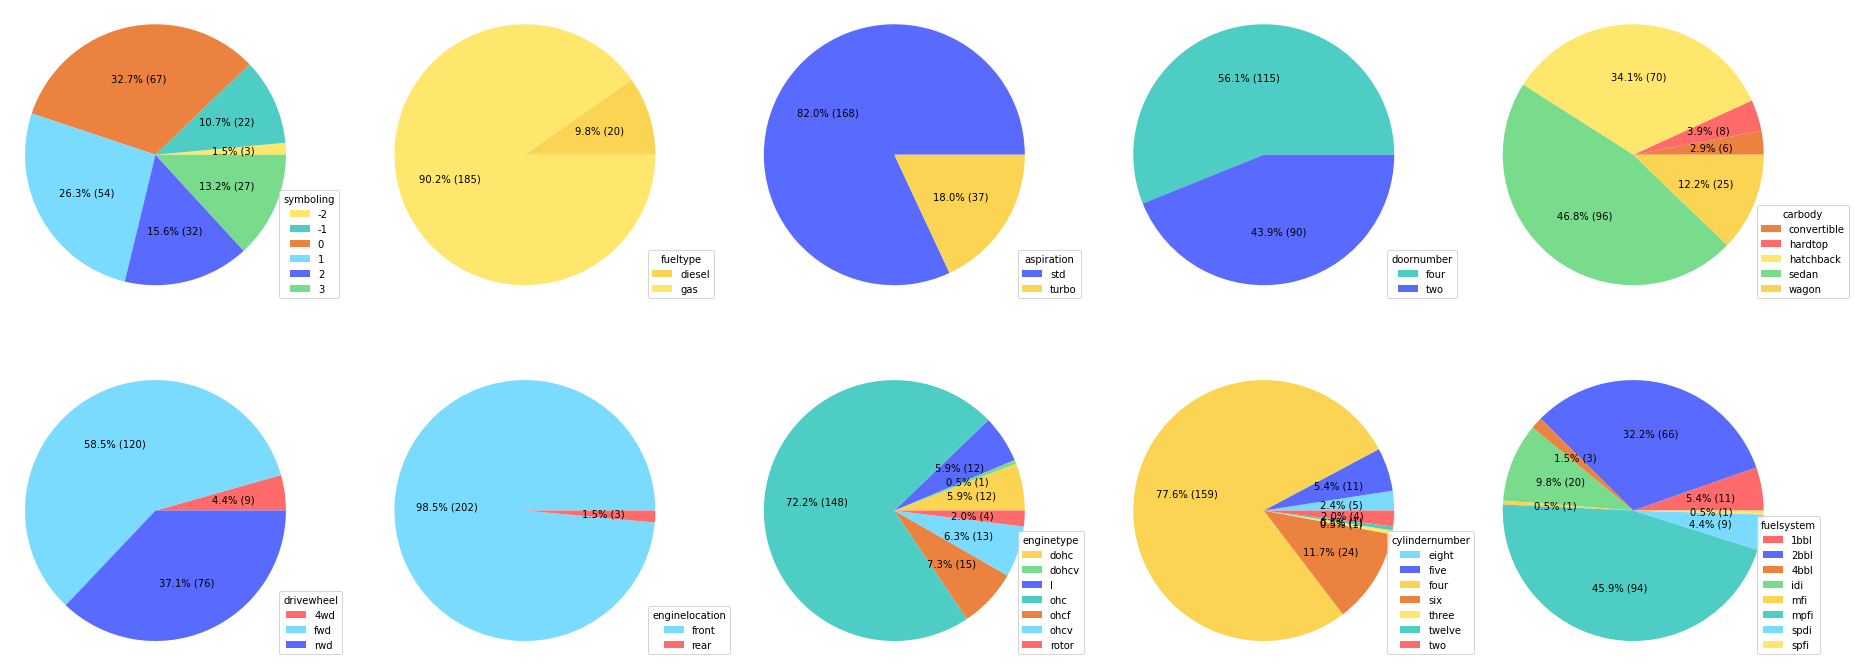

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 12)) 
axes = axes.flatten()
color = ["#596AFF", "#4ECDC4", "#FAD452", "#FF6B6B", "#FFE66D", "#7ADBFF", "#EB8240", "#79DB8C"]
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ({:d})".format(pct, absolute)
for i, cat in enumerate(categorical_cols):
    cross_tab = pd.crosstab(data[cat], columns=["count"])
    y = np.array(cross_tab["count"].values)
    mylabels = cross_tab.index.tolist()
    wedges, texts, autotexts = axes[i].pie(y, autopct=lambda pct: func(pct, y), textprops=dict(color="black"), radius=1.1, colors=np.random.choice(color, len(mylabels), replace=False))
    axes[i].legend(wedges, mylabels,
          title=cat,
          loc="lower left",
          bbox_to_anchor=(0.9, 0, 0, 1))

<AxesSubplot:>

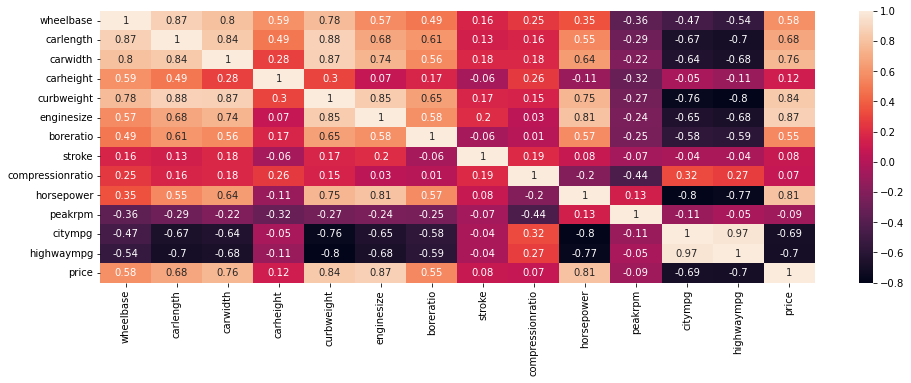

In [11]:
correlation_matrix = data.iloc[:, 1:].corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)

### Fit Model (Full Model):

In [12]:
model = smf.ols("price~symboling+fueltype+aspiration+doornumber+carbody+drivewheel+"
                "enginelocation+wheelbase+carlength+carwidth+carheight+curbweight+" 
                "enginetype+cylindernumber+enginesize+fuelsystem+boreratio+stroke+"
                "compressionratio+horsepower+peakrpm+citympg+highwaympg", data=train_data).fit()

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     55.59
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           3.69e-69
Time:                        15:52:47   Log-Likelihood:                -1644.8
No. Observations:                 184   AIC:                             3380.
Df Residuals:                     139   BIC:                             3524.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2.928e+04   1.08e+04     -2.708      0.008   -5.07e+04   -7900.993
symboling[T.-1]           1151.6693   1715.664      0.671      0.503   -2240.503    4543.842
symboling[T.0]            2646.1862   1713.961      1.544      0.125    -742.620    6034.993
symboling[T.1]            2210.9242   1787.566      1.237      0.218   -1323.412    5745.260
symboling[T.2]            1448.5655   1815.535      0.798      0.426   -2141.069    5038.200
symboling[T.3]            2232.8803   1984.157      1.125      0.262   -1690.151    6155.912
fueltype[T.gas]          -1.827e+04   5631.465     -3.244      0.001   -2.94e+04   -7136.033
aspiration[T.turbo]       1277.9443    882.723      1.448      0.150    -467.357    3023.245
doornumber[T.two]          375.7260    623.098      0.603      0.547    -856.250    1607.702
carbody[T.hardtop]       -5144.7232   1497.388     -3.436      0.001   -8105.326   -2184.121
carbody[T.hatchback]     -4158.2823   1392.663     -2.986      0.003   -6911.825   -1404.740
carbody[T.sedan]         -3248.1854   1510.721     -2.150      0.033   -6235.149    -261.222
carbody[T.wagon]         -4475.8052   1666.372     -2.686      0.008   -7770.518   -1181.092
drivewheel[T.fwd]          603.7052   1059.078      0.570      0.570   -1490.280    2697.690
drivewheel[T.rwd]         1936.2476   1258.089      1.539      0.126    -551.219    4423.714
enginelocation[T.rear]    8682.6315   2796.167      3.105      0.002    3154.112    1.42e+04
enginetype[T.dohcv]      -3718.3669   4829.959     -0.770      0.443   -1.33e+04    5831.321
enginetype[T.l]           -918.5849   1790.957     -0.513      0.609   -4459.625    2622.456
enginetype[T.ohc]         4472.4155   1018.504      4.391      0.000    2458.653    6486.178
enginetype[T.ohcf]        2768.6819   1772.404      1.562      0.121    -735.676    6273.040
enginetype[T.ohcv]       -4047.9794   1319.256     -3.068      0.003   -6656.383   -1439.576
enginetype[T.rotor]        568.0260   2262.013      0.251      0.802   -3904.375    5040.427
cylindernumber[T.five]   -7315.5126   2686.382     -2.723      0.007   -1.26e+04   -2004.058
cylindernumber[T.four]   -8746.8466   3011.771     -2.904      0.004   -1.47e+04   -2792.041
cylindernumber[T.six]    -5089.9588   2221.005     -2.292      0.023   -9481.280    -698.638
cylindernumber[T.three]   2012.3579   4486.212      0.449      0.654   -6857.681    1.09e+04
cylindernumber[T.twelve] -7482.0203   4605.685     -1.625      0.107   -1.66e+04    1624.237
cylindernumber[T.two]      568.0260   2262.013      0.251      0.802   -3904.375    5040.427
fuelsystem[T.2bbl]         307.0840   1019.050      0.301      0.764   -1707.758    2321.926
fuelsystem[T.4bbl]       -1063.9873   2740.965     -0.388      0.698   -6483.363    4355.389
fuelsystem[T.i

#### ANOVA TYP=1

In [14]:
anova_t1 = sm.stats.anova_lm(model, typ=1)
anova_t1["Significant"] = anova_t1.iloc[:, -1] < 0.05
anova_t1

,df,sum_sq,mean_sq,F,PR(>F),Significant
symboling,5.0,2.034484e+09,4.068968e+08,90.343698,6.420917e-42,True
fueltype,1.0,5.105666e+07,5.105666e+07,11.336160,9.833185e-04,True
aspiration,1.0,5.728565e+07,5.728565e+07,12.719189,4.969424e-04,True
doornumber,1.0,3.143331e+07,3.143331e+07,6.979168,9.191372e-03,True
carbody,4.0,1.329843e+09,3.324608e+08,73.816599,1.990712e-33,True
drivewheel,2.0,2.569526e+09,1.284763e+09,285.257198,6.276600e-50,True
enginelocation,1.0,5.566833e+08,5.566833e+08,123.600949,6.142241e-21,True
enginetype,6.0,1.166246e+09,1.943743e+08,43.157127,1.935710e-29,True
cylindernumber,6.0,2.179142e+09,3.631903e+08,80.639502,8.244429e-43,True
fuelsystem,7.0,1.768052e+08,2.525789e+07,5.608034,1.033848e-05,True


#### ANOVA TYP=2

In [15]:
anova_t2 = sm.stats.anova_lm(model, typ=2)
anova_t2["Significant"] = anova_t2.iloc[:, -1] < 0.05
anova_t2

/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F),Significant
symboling,3.419346e+07,5.0,1.518402,1.879000e-01,False
fueltype,4.740691e+07,1.0,10.525804,1.474589e-03,True
aspiration,9.439761e+06,1.0,2.095919,1.499446e-01,False
doornumber,1.637631e+06,1.0,0.363605,5.474936e-01,False
carbody,8.799218e+07,4.0,4.884247,1.025941e-03,True
drivewheel,1.606173e+07,2.0,1.783101,1.719398e-01,False
enginelocation,4.342731e+07,1.0,9.642209,2.305096e-03,True
enginetype,3.851922e+08,6.0,14.254100,1.287703e-12,True
cylindernumber,2.673670e+08,6.0,9.893959,4.449348e-09,True
fuelsystem,5.799603e+07,7.0,1.839559,9.567836e-02,False


#### ANOVA TYP=3

In [16]:
anova_t3 = sm.stats.anova_lm(model, typ=3)
anova_t3["Significant"] = anova_t3.iloc[:, -1] < 0.05
anova_t3

/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F),Significant
Intercept,3.302609e+07,1.0,7.332815,7.621202e-03,True
symboling,3.419346e+07,5.0,1.518402,1.879000e-01,False
fueltype,4.740691e+07,1.0,10.525804,1.474589e-03,True
aspiration,9.439761e+06,1.0,2.095919,1.499446e-01,False
doornumber,1.637631e+06,1.0,0.363605,5.474936e-01,False
carbody,8.799218e+07,4.0,4.884247,1.025941e-03,True
drivewheel,1.606173e+07,2.0,1.783101,1.719398e-01,False
enginelocation,4.342731e+07,1.0,9.642209,2.305096e-03,True
enginetype,3.851922e+08,6.0,14.254100,1.287703e-12,True
cylindernumber,2.673670e+08,6.0,9.893959,4.449348e-09,True


In [17]:
anova1_sign = set(anova_t1.index[anova_t1["Significant"]].tolist())
anova2_sign = set(anova_t2.index[anova_t2["Significant"]].tolist())

In [18]:
anova1_sign.intersection(anova2_sign)

{'carbody',
 'carwidth',
 'curbweight',
 'cylindernumber',
 'enginelocation',
 'enginetype',
 'fueltype',
 'peakrpm',
 'stroke'}

In [19]:
anova1_sign.difference(anova2_sign)

{'aspiration',
 'carlength',
 'doornumber',
 'drivewheel',
 'fuelsystem',
 'symboling',
 'wheelbase'}

**Conclusion for ANOVA Table:**  
`ANOVA Typ1` is sequential ANOVA, so the order of the predictors will affect the significance of the predictors.  
`ANOVA Typ2` is partial ANOVA so the significance result will be the same as t-test result in the summary table and can be different from the `ANOVA Typ1` table.  
`ANOVA Typ3` will have the same result as `ANOVA Typ2`
Both table show that **[carbody, carwidth, curbweight, cylindernumber, enginelocation, enginesize, enginetype, fueltype, peakrpm, stroke]** are the significant predictors of the fitted model.  
`ANOVA Typ1` table shows additional significant predictors: **[aspiration, carlength, doornumber, drivewheel, fuelsystem, horsepower, symboling, wheelbase]**,

#### Full Model: (Prediction):

In [20]:
full_m_predict = model.predict(validate_data)

### Model diagnosis

#### Check Constant Variance

In [21]:
#Breusch-Pagan for Heteroskedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 55.342188829857385, 'LM-Test p-value': 0.18886379994362648}


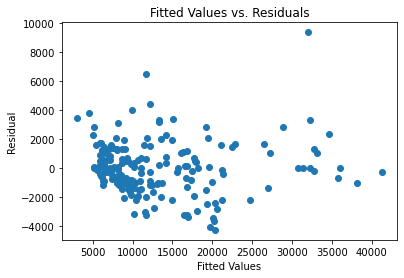

In [22]:
#Heteroscedasticity
#Fitted Values vs. Residuals Plot
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
# plt.hlines(xmin=p.min(), xmax=p.max(), y=10, color='r')
# plt.hlines(xmin=p.min(), xmax=p.max(), y=-10, color='r')
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.show()

Model: $e^2_i = \gamma_0 + \gamma_1 x_{i,1} + ... + \gamma_{p-1} x_{i, p-1} + \xi_i$  
$H_0: \gamma_1+\gamma_2+\gamma_3+...+\gamma_{p-1}=0$  
$H_1:$ at least one $\gamma_k \neq 0$  
$p\_value=0.02646033548618978$  
As $p\_value \lt \alpha$, indicates **significant heteroscendasticity problem**

#### Check Influence Point

In [23]:
num_predictor = int(anova_t3["df"][:-1].sum())
print("Number of predictors: p = ", num_predictor)

Number of predictors: p =  48


In [24]:
infl = model.get_influence()
seuil_stud = scipy.stats.t.ppf(0.975,df=num_data-num_predictor-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud

print("1. Index: ", train_data.index[atyp_stud].values)
print("2. External Studentized Residual: ", reg_studs[atyp_stud])
print("3. Number of observation: ", len(train_data.index[atyp_stud]))

1. Index:  [ 75 134  98  30  16 179 180   3 136   2]
2. External Studentized Residual:  [-2.10256429 -2.75881639  2.10006268  2.21588243  5.72036298 -2.33298023
 -2.18580723  2.04189919  4.21534028  2.79874962]
3. Number of observation:  10


/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [25]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d
atyp_cook = np.abs(reg_cook) >= 4 / num_data
print("1. Index: ", train_data.index[atyp_cook])
print("2. Cook Distance: ", reg_cook[atyp_cook].values)
print("3. Number of observation: ", len(train_data.index[atyp_cook]))

1. Index:  Int64Index([ 18,  75, 155, 134,  98, 125,  58,   9, 103,  30,  66,  16, 101,
            179, 178, 180,   1, 136,   2,  48],
           dtype='int64')
2. Cook Distance:  [4.37872335e-01 3.98993003e-02 3.37312091e-02 3.97481378e-01
 3.33619533e-02 3.02462679e-02 6.98284357e+02 2.89373724e-02
 2.17647043e-02 8.39760288e-02 2.76045782e-02 2.07977849e-01
 2.56958345e-02 3.22046356e-02 2.21017415e-02 2.63256501e-02
 3.65809762e-02 2.28787485e-01 1.18085124e-01 4.20240321e-02]
3. Number of observation:  20


/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:737: RuntimeWarning: invalid value encountered in sqrt
  dffits_ = self.resid_studentized_internal * np.sqrt(hii / (1 - hii))
/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:766: RuntimeWarning: invalid value encountered in sqrt
  dffits_ = self.resid_studentized_external * np.sqrt(hii / (1 - hii))


In [26]:
inf_1 = set(train_data.index[atyp_stud])
inf_2 = set(train_data.index[atyp_cook])
both_inf = inf_1.intersection(inf_2)
print("Observation index both in two method: ", both_inf)

Observation index both in two method:  {98, 2, 134, 136, 75, 16, 179, 180, 30}


#### Delete influential point

In [27]:
new_data = train_data.drop(list(inf_1.intersection(inf_2)))
new_model = smf.ols("price~symboling+fueltype+aspiration+doornumber+carbody+drivewheel+"
                "enginelocation+wheelbase+carlength+carwidth+carheight+curbweight+" 
                "enginetype+cylindernumber+enginesize+fuelsystem+boreratio+stroke+"
                "compressionratio+horsepower+peakrpm+citympg+highwaympg", data=new_data).fit()

In [28]:
#Breusch-Pagan for Heteroskedasticity
bp_test = het_breuschpagan(new_model.resid, new_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 50.55757989920818, 'LM-Test p-value': 0.33488083369163135}


Model: $e^2_i = \gamma_0 + \gamma_1 x_{i,1} + ... + \gamma_{p-1} x_{i, p-1} + \xi_i$  
$H_0: \gamma_1+\gamma_2+\gamma_3+...+\gamma_{p-1}=0$  
$H_1:$ at least one $\gamma_k \neq 0$  
The model without removing influetial points has the pvalue around 0.08 which is really close to the alpha=0.05.  
After removing the influential points, the $p\_value=0.09573324273417373$.  
As $p\_value \gt \alpha$, indicates **no heteroscendasticity problem**

#### Check Normality:

#### old_model (with influential point):

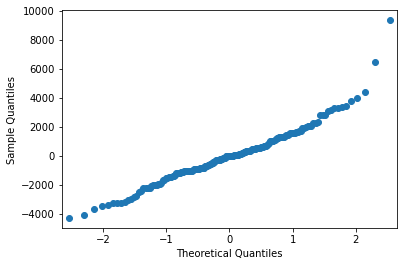

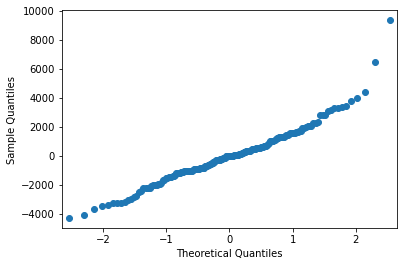

In [29]:
sm.qqplot(model.resid)

#### new_model (w/o influential point)

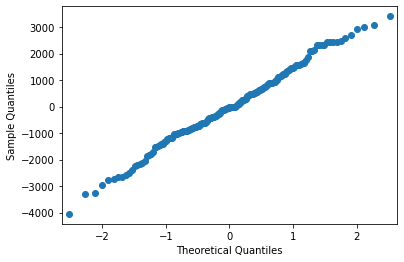

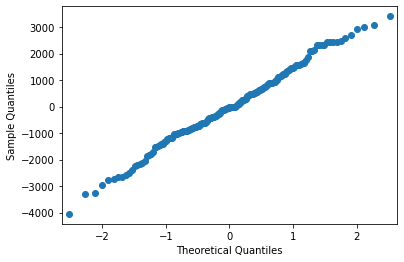

In [30]:
sm.qqplot(new_model.resid)

In [31]:
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     86.39
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           1.65e-77
Time:                        15:52:48   Log-Likelihood:                -1518.9
No. Observations:                 175   AIC:                             3128.
Df Residuals:                     130   BIC:                             3270.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2.749e+04   8647.699     -3.179      0.002   -4.46e+04   -1.04e+04
symboling[T.-1]            836.1544   1361.259      0.614      0.540   -1856.934    3529.243
symboling[T.0]            2463.8340   1372.331      1.795      0.075    -251.159    5178.827
symboling[T.1]            2485.4760   1447.556      1.717      0.088    -378.340    5349.292
symboling[T.2]            1385.3369   1453.603      0.953      0.342   -1490.443    4261.117
symboling[T.3]            3084.3304   1604.152      1.923      0.057     -89.293    6257.954
fueltype[T.gas]          -1.668e+04   4532.396     -3.679      0.000   -2.56e+04   -7709.058
aspiration[T.turbo]        947.5818    711.935      1.331      0.186    -460.897    2356.061
doornumber[T.two]         -395.9059    501.996     -0.789      0.432   -1389.044     597.233
carbody[T.hardtop]       -5551.9256   1214.875     -4.570      0.000   -7955.411   -3148.440
carbody[T.hatchback]     -3783.1455   1133.558     -3.337      0.001   -6025.755   -1540.536
carbody[T.sedan]         -3173.1127   1217.082     -2.607      0.010   -5580.964    -765.262
carbody[T.wagon]         -4373.0782   1339.515     -3.265      0.001   -7023.148   -1723.008
drivewheel[T.fwd]          392.8877    828.195      0.474      0.636   -1245.597    2031.373
drivewheel[T.rwd]         2171.9892   1013.345      2.143      0.034     167.208    4176.770
enginelocation[T.rear]    1.014e+04   2412.841      4.204      0.000    5371.149    1.49e+04
enginetype[T.dohcv]       -640.9392   4422.637     -0.145      0.885   -9390.598    8108.720
enginetype[T.l]          -1871.0391   1524.178     -1.228      0.222   -4886.442    1144.364
enginetype[T.ohc]         4307.0592    970.237      4.439      0.000    2387.562    6226.557
enginetype[T.ohcf]        2945.7684   1722.985      1.710      0.090    -462.952    6354.489
enginetype[T.ohcv]       -4181.2139   1228.255     -3.404      0.001   -6611.169   -1751.259
enginetype[T.rotor]       1404.4848   2370.457      0.592      0.555   -3285.182    6094.151
cylindernumber[T.five]   -5361.2184   2720.931     -1.970      0.051   -1.07e+04      21.818
cylindernumber[T.four]   -5962.5460   3320.256     -1.796      0.075   -1.25e+04     606.183
cylindernumber[T.six]    -3989.4714   2093.490     -1.906      0.059   -8131.191     152.248
cylindernumber[T.three]   7048.2507   4481.916      1.573      0.118   -1818.683    1.59e+04
cylindernumber[T.twelve] -7225.2490   4167.433     -1.734      0.085   -1.55e+04    1019.520
cylindernumber[T.two]     1404.4848   2370.457      0.592      0.555   -3285.182    6094.151
fuelsystem[T.2bbl]         735.7317    874.567      0.841      0.402    -994.494    2465.958
fuelsystem[T.4bbl]        -519.0650   2203.545     -0.236      0.814   -4878.515    3840.385
fuelsystem[T.i

Before removing influential point:  
$p\_value=3.10e-09$ for JB-Test  
$p\_value \lt \alpha$, **Reject $H_0$,** there's **significant** violation of normality  
After removing influential point:  
$p\_value=0.665$ for JB-Test  
$p\_value \gt \alpha$, **Fail to reject $H_0$,** there's **no significant** violation of normality

#### Variant Inflation Factor (VIF):

In [32]:
def vif_elimination(features, data):
    final_features = features.copy()
    n = 0

    while True:
        y, X = dmatrices(
            f'price~{"+".join(final_features)}', data=data, return_type="dataframe"
        )
        vif = pd.DataFrame()
        vif["VIF Factor"] = [
            variance_inflation_factor(X.values, i) for i in range(X.shape[1])
        ]
        vif["features"] = X.columns
        vif = vif[vif["features"] != "Intercept"]

        try:
            feature_to_remove = (
                vif[vif["VIF Factor"] > 10]
                .sort_values("VIF Factor", ascending=False)["features"]
                .to_list()[0]
                .rsplit("[")[0]
            )
            final_features.remove(feature_to_remove)
        except:
            pass

        n = len(vif[vif["VIF Factor"] > 10])
        if n == 0:
            break
    return final_features

In [33]:
features = [
    "fueltype",
    "aspiration",
    "doornumber",
    "carbody",
    "drivewheel",
    "enginelocation",
    "wheelbase",
    "carlength",
    "carwidth",
    "carheight",
    "curbweight",
    "enginetype",
    "cylindernumber",
    "enginesize",
    "fuelsystem",
    "boreratio",
    "stroke",
    "compressionratio",
    "horsepower",
    "peakrpm",
    "citympg",
    "highwaympg"
]

In [34]:
vif_elimination(features, data) 

/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/timho102003/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


['aspiration',
 'doornumber',
 'drivewheel',
 'enginelocation',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'highwaympg']

Summary for VIF process:  
The predictors without violating the multicollinearity issue:  
['aspiration',
 'doornumber',
 'drivewheel',
 'enginelocation',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'highwaympg']

### Model Selection

#### STEP-BIC:

In [35]:
regress = {"price"}
exclude_col = {"car_ID", "CarName"}
include_col = set(new_data.columns.tolist()).difference(exclude_col).difference(regress)

In [36]:
selected_pred = []
min_bic = float('inf')
min_rsq_adj = 0
cnt = 0
while len(selected_pred) < len(include_col):
    diff_pred = include_col.difference(set(selected_pred))
    tmp_bic_ = []
    tmp_adj_rsq_ = []
    for dp in diff_pred:
        tmp_pred = deepcopy(selected_pred)
        tmp_pred.append(dp)
        model_type = list(regress)[0]+"~"+"+".join(tmp_pred)
        tmp_model_ = smf.ols(model_type, data=new_data).fit()
        tmp_bic_.append(tmp_model_.bic)
        tmp_adj_rsq_.append(tmp_model_.rsquared_adj)
    cur_min_bic = min(tmp_bic_)
    if cur_min_bic < min_bic:
        min_idx = tmp_bic_.index(cur_min_bic)
        selected_pred.append(list(diff_pred)[min_idx])
        min_bic = cur_min_bic
        min_rsq_adj = tmp_adj_rsq_[min_idx]
        print(f"############### iter: {cnt} ###############")
        print("Model: ", list(regress)[0]+"~"+"+".join(selected_pred))
        print("BIC: ", cur_min_bic)
        print("Adj-Rsquare: ", min_rsq_adj)
    else:
        print("############### Early Stop! ###############")
        break
    cnt += 1

print("Final Model: ", list(regress)[0]+"~"+"+".join(selected_pred))
print("BIC: ", min_bic)
print("Adj-Rsquare: ", min_rsq_adj)


############### iter: 0 ###############
Model:  price~enginesize
BIC:  3393.758656932689
Adj-Rsquare:  0.7603917880543658
############### iter: 1 ###############
Model:  price~enginesize+cylindernumber
BIC:  3360.896160882129
Adj-Rsquare:  0.8276652418964718
############### iter: 2 ###############
Model:  price~enginesize+cylindernumber+enginelocation
BIC:  3334.0734634787646
Adj-Rsquare:  0.8555895982574061
############### iter: 3 ###############
Model:  price~enginesize+cylindernumber+enginelocation+curbweight
BIC:  3284.774908453503
Adj-Rsquare:  0.8935705333117342
############### iter: 4 ###############
Model:  price~enginesize+cylindernumber+enginelocation+curbweight+enginetype
BIC:  3274.4712355128418
Adj-Rsquare:  0.9107170361647408
############### iter: 5 ###############
Model:  price~enginesize+cylindernumber+enginelocation+curbweight+enginetype+stroke
BIC:  3247.2129784930557
Adj-Rsquare:  0.9253503543778421
############### iter: 6 ###############
Model:  price~enginesize+cyl

In [37]:
new_m_predict = new_model.predict(validate_data)

In [38]:
selected_model = smf.ols(list(regress)[0]+"~"+"+".join(selected_pred), data=train_data).fit()
sel_m_predict = selected_model.predict(validate_data)

In [39]:
compare_df = pd.DataFrame({"Models": ["Full Model(with inf_pt)", "Full Model(w/o inf_pt)", "Selected Model"], 
                           "Adj_RSquare": [model.rsquared_adj, new_model.rsquared_adj, min_rsq_adj], 
                           "BIC": [model.bic, new_model.bic, min_bic],
                           "validate_err": [abs(sum(validate_data["price"] - full_m_predict.values)), 
                                            abs(sum(validate_data["price"] - new_m_predict.values)), 
                                            abs(sum(validate_data["price"] - sel_m_predict.values))]})
compare_df

,Models,Adj_RSquare,BIC,validate_err
0,Full Model(with inf_pt),0.929200,3524.199114,9093.986609
1,Full Model(w/o inf_pt),0.955740,3270.273459,5561.456417
2,Selected Model,0.950933,3206.062805,7514.633702


### Summary:

After removing the influence point, we fix the normality issue and keep the model away from heteroscedasticity.  
We use Step-BIC to find the best model using the updated dataset.  
Final Selected Model:  
`price ~ enginesize + cylindernumber + enginetype + horsepower + carwidth + stroke + compressionratio + enginelocation + curbweight + peakrpm + carlength + doornumber`